In [1]:
# Python script to estimate the STARS foam model parameter from experimental data. 
# This is a python adoption of a Julia script written by A.A. Eftekhari, see https://github.com/simulkade/foamparameters. 
# The optimization solver does not handle the bound constraints very well. It needs to be improved.

In [2]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP
from scipy import stats, optimize
from sklearn import linear_model
mpl.use('TkAgg')
import matplotlib.pyplot as plt
######################################################################
# Plot configurations
# mpl.style.use('classic')
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['lines.dashed_pattern'] = [6, 6]
mpl.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
mpl.rcParams['lines.dotted_pattern'] = [1, 3]
mpl.rcParams['lines.scale_dashes'] = False

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
######################################################################
%matplotlib inline

In [181]:
def find_indices(vector, condition):
    return [i for i, elem in enumerate(vector) if condition(elem)]


def relative_sort(vector1, vector2):
    return [x for _, x in sorted(zip(vector1, vector2))]

##########################$######################################

def sws(s_w):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    n_size = np.size(s_w, 0)
    s_ws = np.zeros((n_size, 1))
    for i in range(0, len(s_w)):
        s = s_w[i]
        if s > swc and s < (1-sgr):
            s_ws[i, 0] = (s-swc)/(1-sgr-swc)
        elif s>=(1-sgr):
            s_ws[i, 0] = 1
    return s_ws


def krg(s_w):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    n_size = np.size(s_w, 0)
    kr_g = np.zeros((n_size, 1))
    for i in range(0, len(s_w)):
        s = s_w[i]
        if s >= swc:
            kr_g[i, 0] = krg0 * (1-sws(s)) ** ng
        elif s<swc:
            kr_g[i, 0] = 1+(krg0-1)/swc * s
    return kr_g


def krw(s_w):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    n_size = np.size(s_w, 0)
    kr_w = np.zeros((n_size, 1))
    for i in range(0, len(s_w)):
        s = s_w[i]
        if s <= (1 - sgr):
            kr_w[i, 0] = krw0 * sws(s) ** nw
        elif s > (1 - sgr):
            kr_w[i, 0] = (-(1 - krw0) / sgr * (1.0 - s) + 1.0)
    return kr_w


def dryout(x, sw):
    return 0.5 + np.arctan(x[1]*(sw-x[2]))/np.pi


def fm_mod_f2(s_w, f2):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    fm = 1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi)
    return fm


def fg_mod_f2(s_w, f2):
    krf = (krg(s_w) / fm_mod_f2(s_w, f2))
    fg = ((krf / mug) / (krw(s_w) / muw + krf / mug))
    return fg


def muf_mod_f2(s_w, f2):
    krf = (krg(s_w) / fm_mod_f2(s_w, f2))
    mu_foam = (1 / (krw(s_w) / muw + krf / mug))
    return mu_foam


def fm_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    mu_f = np.reshape(mu_f, (np.size(mu_f), 1))
    fm = (1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi) *
          (f5[0] / (mu_f * u_t / sigma_wg)) ** f5[1])
    return fm


def fg_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    krf = (krg(s_w) / fm_mod_f2f5(s_w, f2, f5, mu_f, u_t))
    fg = ((krf / mug) / (krw(s_w) / muw + krf / mug))
    return fg


def muf_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    krf = (krg(s_w) / fm_mod_f2f5(s_w, f2, f5, mu_f, u_t))
    mu_foam = (1 / (krw(s_w) / muw + krf / mug))
    return mu_foam
########################################################################


In [175]:
data_file = '/Users/siavash/Rice/SurfactantConcentration/ExperimentalResults/AOSResults/data_AOS10E-1.csv'
header = ['fg', 'dp_tot', 'dp_mid', 'std_tot', 'std_mid', 'mu_tot', 
          'mu_mid', 'stdmu_tot', 'stdmu_mid', 'uw', 'ug', 'ut', 'p_mid', 
          'mu_water']

In [176]:
data = pd.read_csv(data_file, header=None, skiprows = 1, names=header)
data = data.sort_values(by=['fg'])

data['mu_gas'] = np.nan
data['ug_r']=data['ut']*data['fg']
data['uw_r']=data['ut']*(1-data['fg'])
for i in data.index:
    data['mu_gas'].iloc[i]=CP.PropsSI("V", "T", 273.15+30, "P", data['p_mid'].iloc[i], "N2")
n_data = len(data)

sigma_wg = 0.03 

muw = data['mu_water'].iloc[0]
mug = data['mu_gas'].iloc[0]

In [177]:
transition = pd.DataFrame(np.nan,np.arange(1),columns=['trans_ind','fg_trans','mu_trans'])
low_quality = pd.DataFrame(columns=['fg_low','muf_low'])
high_quality = pd.DataFrame(columns=['fg_high','muf_high'])

# transition fron low- to high-quality
transition['trans_ind'] = data['mu_tot'].idxmax(axis=0, skipna=True)
transition['fg_trans']  = data['fg'].iloc[transition['trans_ind'].iloc[0]]
transition['mu_trans']  = data['mu_tot'].iloc[transition['trans_ind'].iloc[0]]

# low quality regime
low_quality.loc[:,'fg_low']= data['fg'].loc[(data['fg'] <= transition['fg_trans'].iloc[0])]
low_quality.loc[:,'muf_low']= data['mu_tot'].loc[(data['fg'] <= transition['fg_trans'].iloc[0])]

# high quality regime
high_quality.loc[:,'fg_high']= data['fg'].loc[(data['fg'] >= transition['fg_trans'].iloc[0])]
high_quality.loc[:,'muf_high']= data['mu_tot'].loc[(data['fg'] >= transition['fg_trans'].iloc[0])]

# Relperm data
swc = 0.05                                                                     # connate water saturation [-]
sgr = 0.03                                                                     # irreducable gas saturation [-]
nw = 4.423                                                                     # Corey water exponent [-]
ng = 0.938                                                                     # Corey gas exponent [-]
krg0 = 0.587                                                                   # endpoint gas relative permeability [-]
krw0 = 0.720

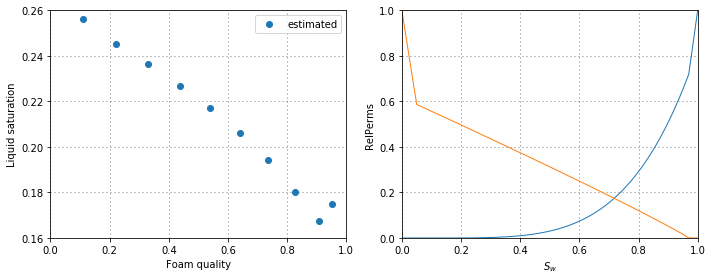

In [246]:
# sw_exp = np.zeros((n_data, 1))
sw_plt = np.reshape(np.linspace(0.0,1.0, 100), (len(np.linspace(0.0,1.0, 100)), 1))

sw_exp = (1-swc-sgr)*(data['mu_water']*(1-data['fg'])/(krw0*data['mu_tot']))**(1/nw)+swc
sw_exp = np.reshape(sw_exp,(len(sw_exp),1))
krg_plt = krg(sw_plt)
krw_plt = krw(sw_plt)

plt.figure(1, figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(data['fg'], sw_exp, "o")
plt.xlabel("Foam quality")
plt.ylabel("Liquid saturation")
plt.legend(["estimated"])
plt.grid()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(sw_plt, krw_plt, sw_plt, krg_plt)
plt.xlabel(r"$S_w$")
plt.ylabel("RelPerms")
plt.grid()
plt.tight_layout()

Fitting parameters from Boeije-Rossen method:
           fmmob     epdry     fmdry     fmcap     epcap
0  465609.643847  100000.0  0.179695  0.000189  2.261177


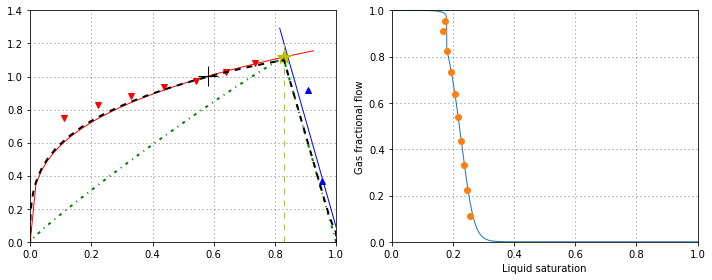

In [248]:
# Boeije-Rossen fitting method
# fit a line to the high quality data | y=a+b*x

# high_qual_append = [1, 0]  
# high_quality.loc[len(high_quality)] = high_qual_append  

reg_high = stats.linregress(high_quality['fg_high'], high_quality['muf_high'])                                    # linear regression for high quality region + [1 0]

a_high = pd.DataFrame(np.nan,np.arange(1),columns=['slope','intercept'])
a_high['slope'] = reg_high[0]
a_high['intercept'] = reg_high[1]

# a = reg_high[0]
# b = reg_high[1]
# a_high = [-a, a]

log_fg_low = np.reshape(np.log(low_quality['fg_low']), (len(low_quality), 1))
log_muf_low = np.reshape(np.log(low_quality['muf_low']), (len(low_quality), 1))
w2  = np.ones(len(low_quality))                                                     # weight factor
w2[-3:] = 5000

linreg = linear_model.LinearRegression()
reg_low = linreg.fit(log_fg_low, log_muf_low, sample_weight=w2)
a_low = pd.DataFrame(np.nan,np.arange(1),columns=['slope','intercept'])
a_low['slope'] = reg_low.coef_
a_low['intercept'] = reg_low.intercept_

low_range = pd.DataFrame(columns=['fg_low_range','muf_low_range'])
high_range = pd.DataFrame(columns=['fg_high_range','muf_high_range'])

low_range.loc[:,'fg_low_range'] = np.linspace(0.0, np.max(low_quality['fg_low'])+0.1, 50) 
low_range.loc[:,'muf_low_range'] = np.exp(a_low['intercept'].iloc[0]) \
                                   *low_range.loc[:,'fg_low_range']**a_low['slope'].iloc[0]

high_range.loc[:,'fg_high_range'] = np.linspace(np.max(low_quality['fg_low'])-0.01, 1.0, 10) 
high_range.loc[:,'muf_high_range']= a_high['intercept'].iloc[0]+a_high['slope'].iloc[0] \
                                    *high_range.loc[:,'fg_high_range']

plt.figure(2, figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(low_quality['fg_low'], low_quality['muf_low'], "vr", 
         low_range['fg_low_range'], low_range['muf_low_range'], "r-")
plt.plot(high_quality['fg_high'], high_quality['muf_high'], "b^",
         high_range['fg_high_range'], high_range['muf_high_range'], "b-")
plt.xlim([0, 1])
plt.grid()
plt.tight_layout()

def fun1(x):
    return np.exp(a_low['intercept'].iloc[0])*x**a_low['slope'].iloc[0] \
    - (a_high['slope'].iloc[0]*x + -a_high['slope'].iloc[0])

sol = optimize.root(fun1, np.max(low_quality['fg_low']))
fg_trans = sol.x

muf_trans = -a_high['slope'].iloc[0]+a_high['slope'].iloc[0]*fg_trans
plt.figure(2, figsize=[10,4])
plt.plot(fg_trans, muf_trans, "*y", markersize=15)
plt.plot([fg_trans, fg_trans], [0.0, 1.1*muf_trans], "--y", linewidth=1)

# find the transition saturation (or fmdry)
sw_trans = (1-swc-sgr)*(data['mu_water'].iloc[transition['trans_ind'].iloc[0]]* \
                        (1-fg_trans)/(krw0*muf_trans))**(1/nw)+swc
fmdry_br = sw_trans

# find fmmob
muw1 = data['mu_water'].iloc[transition['trans_ind'].iloc[0]]
mug1 = data['mu_gas'].iloc[transition['trans_ind'].iloc[0]]
FM_trans = mug1/muw1 * fg_trans/(1-fg_trans)*(krw(sw_trans)/krg(sw_trans))
fmmob_br = 1.0/FM_trans-1.0

# find epdry
epdry_br= 100000.0
x_br = np.reshape([float(fmmob_br), float(epdry_br), float(fmdry_br)],(3, 1))

sw_val1 = np.append(np.linspace(0.0, np.min(sw_exp), 100),
                     np.linspace(np.min(sw_exp)+np.finfo(float).eps, np.max(sw_exp), 100))
sw_val = np.append(sw_val1, np.linspace(np.max(sw_exp) + np.finfo(float).eps, 1.0, 100))

fg_opt = fg_mod_f2(sw_val, x_br)
muf_opt = muf_mod_f2(sw_val, x_br)
plt.plot(fg_opt, muf_opt, "-.g", linewidth=2)

# calculate the epcap
fg_plus = 0.7 * fg_trans

muf_plus = np.exp(a_low['intercept'].iloc[0])*fg_plus**a_low['slope'].iloc[0]
plt.plot(fg_plus, muf_plus, "k+", markersize=20)

sw_plus  = (1-swc-sgr)*(muw1*(1-fg_plus)/(krw0*muf_plus))**(1/nw)+swc

epcap_br = np.log((krg(sw_trans)*muf_plus-fg_plus*mug1)/
           (fmmob_br*mug1*fg_plus))/np.log(muf_trans/muf_plus)

# calculate fmcap
transition['trans_ind'] = data['mu_tot'].idxmax(axis=0, skipna=True)
ind_muf_min = data['mu_tot'].idxmin(axis=0, skipna=True)
fmcap_br = data['mu_tot'].iloc[ind_muf_min]*data['ut'].iloc[ind_muf_min]/sigma_wg
# correct for fmmob
fmmob_br_new = fmmob_br*(muf_trans/data['mu_tot'].iloc[ind_muf_min])**epcap_br
x_br2 = np.reshape([float(fmmob_br_new), float(epdry_br), float(fmdry_br), float(fmcap_br), float(epcap_br)],(5, 1))
n1 = np.size(sw_val)
muf_br = np.zeros((n1, 1))
u_min = np.min(data['ut'])
u_max = np.max(data['ut'])
u_ave = float(np.mean(data['ut']))
#
F2 = [float(x_br2[0, 0]), float(x_br2[1, 0]), float(x_br2[2, 0])]
F5 = [float(x_br2[3, 0]), float(x_br2[4, 0])]

F2 = [x_br2[0, 0], x_br2[1, 0], x_br2[2, 0]]
F5 = [x_br2[3, 0], x_br2[4, 0]]

for i in range(0, n1):
    sw_p = float(sw_val[i])

    def fmu(x):
        return float(x - muf_mod_f2f5(sw_p, F2, F5, x, u_ave))

    sol = optimize.root(fmu, 0.9)
    muf_br[i, 0] = sol.x


fg_br = fg_mod_f2f5(sw_val, F2, F5, muf_br, u_ave)
muf_mod_br = muf_mod_f2f5(sw_val, F2, F5, muf_br, u_ave)

plt.plot(fg_br, muf_mod_br, "k--", linewidth=2)
plt.subplot(1,2,2)
plt.plot(sw_val, fg_br, sw_exp, data['fg'], "o")
plt.xlabel("Liquid saturation")
plt.ylabel("Gas fractional flow")
plt.grid()
plt.tight_layout()

fit_br = np.array([fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br])

param_br = pd.DataFrame(np.nan,np.arange(1),columns = ['fmmob','epdry','fmdry','fmcap','epcap'])
param_br['fmmob'] = fmmob_br_new
param_br['epdry'] = epdry_br
param_br['fmdry'] = fmdry_br
param_br['fmcap'] = fmcap_br
param_br['epcap'] = epcap_br


print("Fitting parameters from Boeije-Rossen method:")
print(param_br)
# ##############################################################################


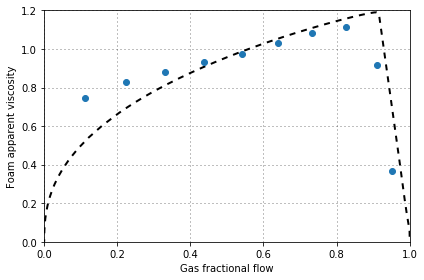

          fmmob        epdry     fmdry     fmcap     epcap
0  29158.555208  9662.262239  0.157774  0.000756  1.362137


In [253]:
# Least square 
labdaw = krw(sw_exp)/np.reshape(data['mu_water'],(len(data['mu_water']), 1))                                                 # water mobility
labdag = krg(sw_exp)/np.reshape(data['mu_gas'],(len(data['mu_water']), 1))    

w = np.ones((np.size(sw_exp), 1))
w[transition['trans_ind'].iloc[0]-4:transition['trans_ind'].iloc[0]] = 1e7
w[transition['trans_ind'].iloc[0]+1:transition['trans_ind'].iloc[0]+2] = 5e2

muf_exp = np.reshape(data['mu_tot'],(len(data['mu_tot']),1))
u = np.reshape(data['ut'],(len(data['ut']),1))

def misfit(x):
    return sum(w*(1.0-(1.0/(labdaw+labdag/(1.0+x[0]*(0.5+np.arctan(x[1]*(sw_exp-x[2]))/np.pi)*
                                           (x[3]/(u*muf_exp/sigma_wg))**x[4])))/muf_exp)**2)

x0 = np.array([1e4, 1e4, 0.15, 0.001, 1.5])
bound = ([10,10,swc,1e-4,1] , [1e8,1e5,sw_trans,1e-2,4])

es = optimize.least_squares(misfit, x0,
                       bounds=bound)

foam_param = np.zeros((5, 0))
foam_param = es.x
foam_param = np.reshape(foam_param, (len(foam_param), 1))

sw_val1 = np.append(np.linspace(0.0, np.min(sw_exp), 100),
                     np.linspace(np.min(sw_exp)+np.finfo(float).eps, np.max(sw_exp), 100))
sw_val = np.append(sw_val1, np.linspace(np.max(sw_exp) + np.finfo(float).eps, 1.0, 100))

n1 = np.size(sw_val)
muf_opt = np.zeros((n1, 1))
u_min = np.min(data['ut'])
u_max = np.max(data['ut'])
u_ave = float(np.mean(data['ut']))

F22 = [foam_param[0, 0], foam_param[1, 0], foam_param[2, 0]]
F52 = [foam_param[3, 0], foam_param[4, 0]]

for i in range(0, n1):
    sw_p = float(sw_val[i])

    def fmu2(x):
        return float(x - muf_mod_f2f5(sw_p, F22, F52, x, u_ave))

    sol = optimize.root(fmu2, 0.9)
    muf_opt[i, 0] = sol.x


fg_opt = fg_mod_f2f5(sw_val, F22, F52, muf_opt, u_ave)
muf_mod_opt = muf_mod_f2f5(sw_val, F22, F52, muf_opt, u_ave)

plt.figure(3)
plt.plot(fg_opt, muf_mod_opt, "k--", linewidth=2)
plt.plot(data['fg'], data['mu_tot'], "o")
plt.ylabel("Foam apparent viscosity")
plt.xlabel("Gas fractional flow")
plt.grid()
plt.tight_layout()

plt.show()

param_ls = pd.DataFrame(np.nan,np.arange(1),columns = ['fmmob','epdry','fmdry','fmcap','epcap'])
param_ls['fmmob'] = foam_param[0, 0]
param_ls['epdry'] = foam_param[1, 0]
param_ls['fmdry'] = foam_param[2, 0]
param_ls['fmcap'] = foam_param[3, 0]
param_ls['epcap'] = foam_param[4, 0]

print(param_ls)

/Users/siavash/Software/anaconda2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)


         Current function value: 1942.829806
         Iterations: 4
         Function evaluations: 642
         Gradient evaluations: 105
     fun: 1942.8298062667823
     jac: array([ -5.17103485e+01,   5.41237127e+02,   1.47186327e+05,
        -6.75877363e+04])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 642
     nit: 4
    njev: 105
  status: 2
 success: False
       x: array([  1.00000000e+03,   1.49999997e-01,   1.83369819e-03,
         2.50000031e+00])
[[  1.00000000e+03]
 [  1.00000000e+05]
 [  1.49999997e-01]
 [  1.83369819e-03]
 [  2.50000031e+00]]


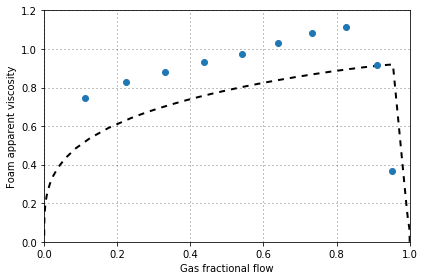

In [10]:
labdaw = krw(sw_exp)/muw                                                  # water mobility
labdag = krg(sw_exp)/mug

# x0 = np.array([100000, 100000, 0.1696, 0.000175, 2.2222])
x0 = np.array([1000, 0.15, 0.0001, 2.5])
bound = ((10, 1e8), (swc, sw_trans), (1e-4, 1e-2), (2, 4))

w = np.ones((np.size(sw_exp), 1))
w[int(ind_mu_max)-4:int(ind_mu_max)] = 1e0
w[int(ind_mu_max)+1:int(ind_mu_max)+2] = 5e5


def misfit(x):
    return sum(w*(1.0-(1.0/(labdaw+labdag/(1.0+x[0]*(0.5+np.arctan(1e5*(sw_exp-x[1]))/np.pi)*(x[2]/(u*muf_exp/sigma_wg))**x[3])))/muf_exp)**2)

es = optimize.minimize(misfit, x0, method='CG', bounds=bound, options={'disp': True, 'eps': 1e-4})

print(es)
foam_param = np.zeros((5, 0))
foam_param = np.insert(es.x, 1, 1e5)
foam_param = np.reshape(foam_param, (len(foam_param), 1))

sw_val1 = np.append(np.linspace(0.0, np.min(sw_exp), 100),
                     np.linspace(np.min(sw_exp)+np.finfo(float).eps, np.max(sw_exp), 100))
sw_val = np.append(sw_val1, np.linspace(np.max(sw_exp) + np.finfo(float).eps, 1.0, 100))

n1 = np.size(sw_val)
muf_opt = np.zeros((n1, 1))
u_min = np.min(u)
u_max = np.max(u)
u_ave = float(np.mean(u))

F22 = [foam_param[0, 0], foam_param[1, 0], foam_param[2, 0]]
F52 = [foam_param[3, 0], foam_param[4, 0]]

print(foam_param)
for i in range(0, n1):
    sw_p = float(sw_val[i])

    def fmu2(x):
        return float(x - muf_mod_f2f5(sw_p, F22, F52, x, u_ave))

    sol = optimize.root(fmu2, 0.9)
    muf_opt[i, 0] = sol.x


fg_opt = fg_mod_f2f5(sw_val, F22, F52, muf_opt, u_ave)
muf_mod_opt = muf_mod_f2f5(sw_val, F22, F52, muf_opt, u_ave)

plt.figure(3)
plt.plot(fg_opt, muf_mod_opt, "k--", linewidth=2)
plt.plot(fg_exp, muf_exp, "o")
plt.ylabel("Foam apparent viscosity")
plt.xlabel("Gas fractional flow")
plt.grid()
plt.tight_layout()

plt.show()
